In [ ]:
import re
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np 
import nltk
nltk.download('stopwords')
import spacy
import string
pd.options.mode.chained_assignment = None

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/soft_ass_3/Dataset-2-2.csv",engine='python')


In [ ]:
df.columns = ["text", "lebel"]
df["text"] = df["text"].str.lower()
df.head()

,text,lebel
0,is reading manga http://plurk.com/p/mzp1e,0
1,@comeagainjen http://twitpic.com/2y2lx - http:...,0
2,@lapcat need to send 'em to my accountant tomo...,0
3,add me on myspace!!! myspace.com/lookthunder,0
4,so sleepy. good times tonight though,0


In [ ]:
def remove_users(text):
    
    text = re.sub('(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', text)  
    text = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', text)  
    return text
df['text'] = np.vectorize(remove_users)(df['text']) 

def remove_links(text):
    
    text = re.sub(r'http\S+', '', text)   
    text = re.sub(r'bit.ly/\S+', '', text)  
    text = text.strip('[link]')   
    text = re.sub(r'pic.twitter\S+','', text)
    return text
df["text"] = df["text"].apply(lambda text: remove_links(text))

def remove_hashtags(text):
    
    text = re.sub('(#[A-Za-z]+[A-Za-z0-9-_]+)', '', text)  
    return text
df["text"] = df["text"].apply(lambda text: remove_hashtags(text))



In [ ]:
df.head()

,text,lebel
0,s reading manga,0
1,-,0
2,need to send 'em to my accountant tomorrow. o...,0
3,add me on myspace!!! myspace.com/lookthunder,0
4,so sleepy. good times tonight though,0


In [ ]:
import string
PUNCT_TO_REMOVE = string.punctuation
def remove_punctuation(text):
    
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

df["text"] = df["text"].apply(lambda text: remove_punctuation(text))
df.head()

,text,lebel
0,s reading manga,0
1,,0
2,need to send em to my accountant tomorrow odd...,0
3,add me on myspace myspacecomlookthunder,0
4,so sleepy good times tonight though,0


In [ ]:
from nltk.corpus import stopwords
", ".join(stopwords.words('english'))

"i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, had, having, do, does, did, doing, a, an, the, and, but, if, or, because, as, until, while, of, at, by, for, with, about, against, between, into, through, during, before, after, above, below, to, from, up, down, in, out, on, off, over, under, again, further, then, once, here, there, when, where, why, how, all, any, both, each, few, more, most, other, some, such, no, nor, not, only, own, same, so, than, too, very, s, t, can, will, just, don, don't, should, should've, now, d, ll, m, o, re, ve, y, ain, aren, aren't, couldn, couldn't, didn, didn't, doesn, doesn't, hadn, hadn't, hasn, hasn't, haven, haven't, isn, isn't, ma, mightn, mightn't, mustn, mus

In [ ]:

STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(text):
   
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

df["text"] = df["text"].apply(lambda text: remove_stopwords(text))
df.head()

,text,lebel
0,reading manga,0
1,,0
2,need send em accountant tomorrow oddly wasnt e...,0
3,add myspace myspacecomlookthunder,0
4,sleepy good times tonight though,0


In [ ]:
 import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

df["text"] = df["text"].apply(lambda text: lemmatize_words(text))
df.head()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


,text,lebel
0,reading manga,0
1,,0
2,need send em accountant tomorrow oddly wasnt e...,0
3,add myspace myspacecomlookthunder,0
4,sleepy good time tonight though,0


In [ ]:
df["text"] = df["text"].apply(lambda text: [w for w in str(text).split() if w.isalpha()] )

df.head()

,text,lebel
0,"[reading, manga]",0
1,[],0
2,"[need, send, em, accountant, tomorrow, oddly, ...",0
3,"[add, myspace, myspacecomlookthunder]",0
4,"[sleepy, good, time, tonight, though]",0


In [ ]:
df.to_csv(r"preprocessed_dataset.csv",header=None, index=False)

In [ ]:
df = pd.read_csv("/content/preprocessed_dataset.csv", header=None,engine="python")
df.columns = ["text", "lebel"]
df.isnull().sum()
df1=df
df1.dropna(inplace = True)
df1.isnull().sum()
df1.to_csv(r"final_preprocessed_dataset.csv",header=None, index=False)


In [ ]:
df = pd.read_csv("/content/final_preprocessed_dataset.csv", header=None,engine='python')


In [ ]:

class Sequences(Dataset):
    def __init__(self, data):
        self.vectorizer = CountVectorizer(stop_words='english')
        self.sequences = self.vectorizer.fit_transform(data.text.tolist())
        self.lebels = data.lebel.tolist()
        self.token2idx = self.vectorizer.vocabulary_
        self.idx2token = {idx: token for token, idx in self.token2idx.items()}
    
    def __getitem__(self, i):
        return self.sequences[i, :].toarray(), self.lebels[i]
    
    def __len__(self):
        return self.sequences.shape[0]


df = pd.read_csv("/content/final_preprocessed_dataset.csv", header=None,engine="python")        

In [ ]:

df = pd.read_csv("/content/final_preprocessed_dataset.csv", header=None,engine="python")

df.columns = ["text", "lebel"]


train_size=int(len(df)*0.7)
df_train = df.head(train_size)
df_test = df.tail(int(len(df)*0.3))
dataset = Sequences(df_train)
train_loader = DataLoader(dataset, batch_size=900)






In [ ]:
# Hyper-parameters
sequence_length = 28
hidden_size = 128
num_layers = 3
num_classes = 1
batch_sizeRNN = 100
num_epochs = 2
learning_rate = 0.001

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True,bidirectional=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
      
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)    
       
        out, _ = self.rnn(x, h0)  
        
        out = self.fc(out[:, -1, :])
        return out

In [ ]:
model = RNN(len(dataset.token2idx), hidden_size, num_layers,num_classes).to(device)

In [ ]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:

train_losses = []
iter = 0
total_step = train_size
for epoch in range(20):
    losses = []
    total = 0
    for inputs, target in train_loader:
        
        inputs=inputs.float()
        inputs=inputs.to(device)
       
        targets=target.float()
        target=targets.to(device)

        model.zero_grad()

        output = model(inputs)
        loss = criterion(output.squeeze(), target)
        
        loss.backward()
          
        optimizer.step()
        
        losses.append(loss.item())
        total += 1
        
    epoch_loss = sum(losses) / total
    train_losses.append(epoch_loss)
        
    print(f'Epoch #{epoch + 1}\tTrain Loss: {epoch_loss:.10f}')
    
    

Epoch #1	Train Loss: 0.2351980085
Epoch #2	Train Loss: 0.0027558787
Epoch #3	Train Loss: 0.0001497636
Epoch #4	Train Loss: 0.0000620166
Epoch #5	Train Loss: 0.0000450655
Epoch #6	Train Loss: 0.0000394724
Epoch #7	Train Loss: 0.0000371512
Epoch #8	Train Loss: 0.0000360002
Epoch #9	Train Loss: 0.0000352985
Epoch #10	Train Loss: 0.0000347716
Epoch #11	Train Loss: 0.0000343096
Epoch #12	Train Loss: 0.0000338682
Epoch #13	Train Loss: 0.0000334303
Epoch #14	Train Loss: 0.0000329929
Epoch #15	Train Loss: 0.0000325474
Epoch #16	Train Loss: 0.0000321005
Epoch #17	Train Loss: 0.0000316520
Epoch #18	Train Loss: 0.0000311999
Epoch #19	Train Loss: 0.0000307483
Epoch #20	Train Loss: 0.0000302937


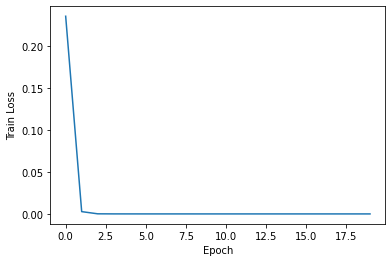

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_losses)
plt.ylabel('Train Loss')
plt.xlabel('Epoch')
plt.show()

In [ ]:
def predict_sentiment(text):
  test_vector= torch.LongTensor(dataset.vectorizer.transform([text]).toarray()).to(device)

  test_vector=test_vector.unsqueeze(1)
  output = model(torch.tensor(test_vector , dtype=torch.float))
  prediction = torch.sigmoid(output).item()
  
  if prediction < 0.5:
    print(f'{prediction:0.3}: Positive sentiment')
    return 1
  else:
    print(f'{prediction:0.3}: Negative sentiment')
    return 0

In [ ]:
test_text = "Happy Birthday."
predict_sentiment(test_text)

0.000448: Positive sentiment


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


1

In [ ]:
test_text = "I kill you."
predict_sentiment(test_text)

0.941: Negative sentiment


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


0

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

pred_lebels = []

sentences = list(df_test['text'])
lebels = df_test['lebel']

print(sentences)

for sentence in sentences:
  pred_lebels.append(predict_sentiment(sentence))



["['class', 'bad', 'depressionclasses', 'bad', 'depressio']", "['got', 'depression', 'lo']", "['make', 'feel', 'bad', 'depression', 'like']", "['depression', 'oh', 'sorry', 'thats', 'one', 'five', 'stage', 'something', 'else', 'relevant']", "['joking', 'think', 'bipolar', 'disorder', 'cause', 'manic', 'episode', 'followed', 'period', 'crippling', 'depression', 'behavior', 'go', 'back', 'year']", "['psa', 'call', 'someone', 'struggling', 'depression', 'anxiety', 'etc', 'crazy', 'piece', 'crap']", "['isnt', 'elderly', 'people', 'need', 'hen', 'power', 'benefit', 'low', 'point', 'able', 'work', 'struggling', 'depression', 'chronic', 'fatigue', 'hen']", "['dwayne', 'johnson', 'praised', 'opening', 'battle', 'wdepression', 'cry', 'constantly']", "['dan', 'speech', 'depression', 'anxiety', 'going', 'therapist', 'stigmatised', 'society', 'love', 'much']", "['feel', 'like', 'postpartum', 'depression']", "['ce', 'delay', 'depression', 'guideline', 'labelled', 'fit', 'purpose', 'gp', 'expert', '

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


0.96: Negative sentiment
0.999: Negative sentiment
0.996: Negative sentiment
0.327: Positive sentiment
0.00172: Positive sentiment
0.964: Negative sentiment
0.962: Negative sentiment
0.00292: Positive sentiment
0.0452: Positive sentiment
0.995: Negative sentiment
0.995: Negative sentiment
0.000322: Positive sentiment
0.000466: Positive sentiment
0.000176: Positive sentiment
0.271: Positive sentiment
0.814: Negative sentiment
0.000199: Positive sentiment
0.18: Positive sentiment
6.19e-05: Positive sentiment
0.946: Negative sentiment
0.379: Positive sentiment
0.00762: Positive sentiment
0.992: Negative sentiment
0.000432: Positive sentiment
0.999: Negative sentiment
1.0: Negative sentiment
0.896: Negative sentiment
0.000201: Positive sentiment
0.792: Negative sentiment
0.988: Negative sentiment
6.2e-05: Positive sentiment
0.135: Positive sentiment
0.651: Negative sentiment
0.0159: Positive sentiment
0.00126: Positive sentiment
0.998: Negative sentiment
0.303: Positive sentiment
0.0192: P

In [ ]:

accuracy = accuracy_score(lebels, pred_lebels)
print('Accuracy: %f' % accuracy)

precision = precision_score(lebels, pred_lebels)
print('Precision: %f' % precision)

recall = recall_score(lebels, pred_lebels)
print('Recall: %f' % recall)

f1 = f1_score(lebels, pred_lebels)
print('F1 score: %f' % f1)


matrix = confusion_matrix(lebels, pred_lebels)
print(matrix)

Accuracy: 0.748141
Precision: 0.748141
Recall: 1.000000
F1 score: 0.855928
[[   0  779]
 [   0 2314]]



Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       779
           1       0.75      1.00      0.86      2314

    accuracy                           0.75      3093
   macro avg       0.37      0.50      0.43      3093
weighted avg       0.56      0.75      0.64      3093



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


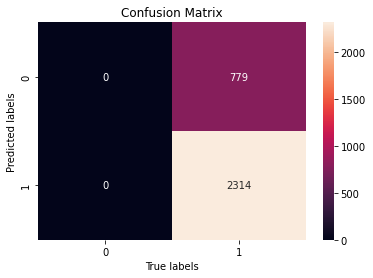

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn import metrics    

ax= plt.subplot()

cm = confusion_matrix(lebels, pred_lebels)
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  


ax.set_xlabel('True labels');ax.set_ylabel('Predicted labels'); 
ax.set_title('Confusion Matrix'); 
print('\nClassification Report:\n' + str(metrics.classification_report(lebels, pred_lebels)))